# A first glance at the data
---
### Where to start?
The first thing to do after putting together a new dataset is to check what (if any) insights can be gained from it. I assembled the data to learn more about migration and refugee movement. One immediate reaction might be to assume that migration should be directly linked to economic growth - a country with growing economy will attract people; a country with shrinking economy will loose population. But does the data support this simplistic view? Is there maybe more that we could extract?

### What to do?

I figured that one way to check this assumption would be to see if the indicators are directly correlated. To make my live a bit easier I am solely interested if the general trend correlates, i.e. does one indicator always grow if the other does? In the following I will follow this line of thought and look at the data.

## Load the data

In [1]:
%pylab inline
import sys
sys.path.append("../lib/")

import seaborn as sns
import pandas  as pd
from operator  import itemgetter

from dataContainer import DataContainer, dataClassMapper

Populating the interactive namespace from numpy and matplotlib


The ```DataContainer``` class is a container that integrates the available datasets. It allows easy loading and combining (and hopefully more cool stuff in the future). The UNHCR and OECD migration data includes information about the country of origin of the migration. For now this information is not needed and we can combine the data using the ```collapse()``` method.

In [2]:
container = DataContainer()              # load the data
data      = container.collapse()         # remove the country of origin information
data      = container.orderColumns(data) # order the columns based on category, i.e. education, economy, etc.

To get a good sense of the data without being totaly overwhelmed by all the missing values we will drop every indicator which has more than 50% missing values. This typically happens if the indicator was introduced recently and no information about the past is available, or if this particular information is difficult to collect.

In [3]:
nrows, ncol = np.shape(data)
keepColumns = list()

for column in data.columns:
    if data[column].notnull().sum() >= nrows*0.5:
        keepColumns.append(column)

dataReduced = data[keepColumns] # reduce the dataset
        
print("Selected %i out of %i indicators with not more than 50%% missing values" %(len(keepColumns), ncol))

Selected 78 out of 177 indicators with not more than 50% missing values


This reduced data can now be grouped by country and the correlation matrix can be calculated. Notice that the correlation will be calculated on the (binary) difference matrix. If an indicator was increasing compared to the year before it will be set to +1, if it decreased it will be set to -1.

In [4]:
allData = dict()

for name, group in dataReduced.groupby(["Country"]):
    del group["Country"]
    del group["Year"]
    diffmat = group.diff()
    diffmat[diffmat<=0] = -1
    diffmat[diffmat >0] = 1
    corrmat = diffmat.corr()
    allData[name] = corrmat

Here we created a dictionary that holds the correlation matrix for each country. One easy way to obtain an average correlation matrix from this is to use pandas Panels. Once put into the panel object we can easily compute the average and standart deviation across the DataFrames.

In [5]:
pan = pd.Panel(allData)
m   = pan.mean(axis=0) # the mean of the correlation across countries
s   = pan.std( axis=0) # the standard deviation of the correlation across countries

In order to produce a nice plot we need to do some tricks. The indicators are grouped by categories (see the [wiki](https://github.com/nberliner/delveData/wiki) for more information). Guides in the following heatmap should be plotted to indicate these different groups. Assuming that the categorisation of the indicators was done sensibly, stronger correlation between indicators within one group compared to inter-group correlations should be observed. The next few steps can safely be ignored. They are simply there to add the lines and labels to the plot.

In [6]:
mapper = dataClassMapper() # the dataClassMapper allows mapping of short indicator IDs to human readible output
labels = list()            # will contain for each position the category of its indicator
for idx, name in enumerate(m.columns):
    labels.append((idx, mapper(name)[0]))

In [7]:
df = pd.DataFrame(labels) # convert to DataFrame to allow grouping
category_ticks = list()   # will contain for each category the starting and ending index
for category, group in df.groupby(1):
    category_ticks.append((category, np.min(group[0]), np.max(group[0])))

category_ticks = sorted(category_ticks, key=itemgetter(1)) # sort based on the starting index

In [8]:
placeTicksHere = [ i[1]+np.floor((i[2] -i[1])/2) for i in category_ticks ] # calculate the tick position
ticks          = list()                                                    # the axes tick labels

count = 0
for i in range(len(labels)):
    if i in placeTicksHere:
        ticks.append(category_ticks[count][0]) # append the category name
        count += 1
    else:
        ticks.append("") # nothing to show

Finally we can plot the average correlation between the indicators over all countries.

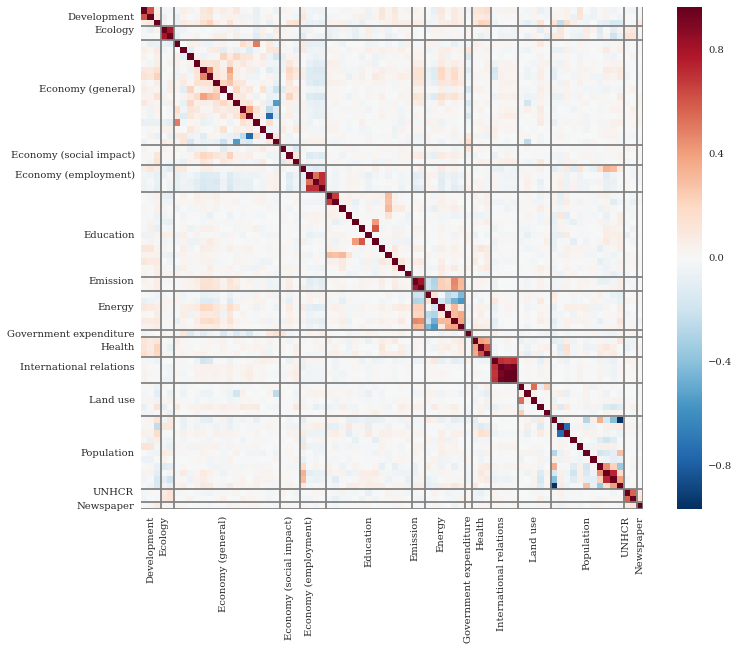

In [9]:
f, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(m, vmax=.8, square=True, xticklabels=ticks, yticklabels=ticks, ax=ax)

linesHere = [ item[2] + 1 for item in category_ticks ]
for i in linesHere:
    ax.axhline(np.shape(s)[0]-i, c="grey")
    ax.axvline(i, c="grey")

#### What do we see in this plot?
Plotted is the average correlation between the indicators over all countries. The indicators are plotted along each axes so that the diagonal is the correlation of the indicators with themselves. Red color indicates positive correlation and blue stands for negative correlation. The grey lines seperate the categories (as described in the [wiki](https://github.com/nberliner/delveData/wiki)).

#### What do we learn from this plot?
First of all we can see that the categorisation we made earlier is apparently in accordance with the data. A correlation between intra-category indicators can be observed (the squares seen along the diagonal). However there does not appear to be a simple answer for inter-category relationships between the indicators. The data do not support the simplistic idea that economy correlates with migration on a global scale. Remember that this is a global average!

---

Next, we can investigate the variation in the correlation per country. This will give an idea about how well the correlation agrees between countries (small variance compared to big variance in the correlation coefficient).

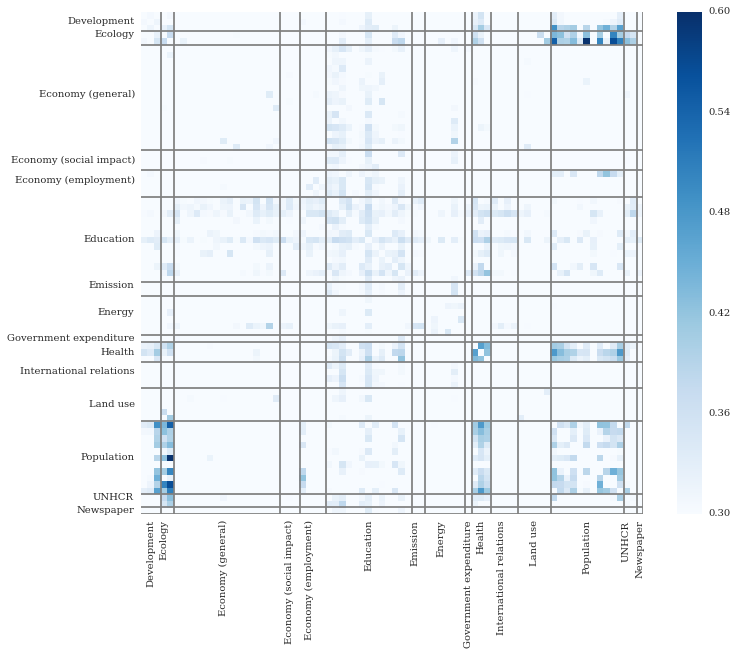

In [10]:
f, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(s, vmin=.3, vmax=.6, square=True, xticklabels=ticks, yticklabels=ticks, ax=ax, cmap="Blues")

linesHere = [ item[2] + 1 for item in category_ticks ]
for i in linesHere:
    ax.axhline(np.shape(s)[0]-i, c="grey")
    ax.axvline(i, c="grey")

#### What do we see in this plot?
Plotted is the standard deviation of the correlations between the indicators over all countries.

#### What do we learn from this plot?
The result of this plot, to me, is very interesting. There are three aspects that strike me most. First, the relationship between health related indicators and population based measures does not seem to follow a global trend. Second, correlations between population and ecology measures severly differ between countries. Lastly, education in general does not seem to follow global trends. Especially the correlation of intra-category education measures seems to be consistently dependend on the country.

The (partly) strong variations in the observed correlation suggest that there might be a more complex relationship hidden in the data that is worth to be explored!

In [11]:
# Save the last figure
import time
fname = "%i%i%i_std_CorrMatrixGlobal.png" %(time.localtime()[0], time.localtime()[1], time.localtime()[2])
f.tight_layout()
f.savefig(fname, dpi=120)